In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df = pd.read_spss('/media/data/personality/OOS Master Dataset Sept 2022/00_OOS_MASTER DATASET_2022_08_22.sav')
# plot histograms of all numeric variables and save to "figs/initial_histograms" directory
os.makedirs('figs/initial_histograms', exist_ok=True)
for col in df.select_dtypes(include='number'):
    try:
        df[col].hist()
        plt.title(col)
        plt.savefig(f'figs/initial_histograms/{col}.png')
        plt.close()
    except Exception as e:
        print(f'Error with {col}: {e}')
        continue

In [ ]:
df = pd.read_spss('/media/data/personality/OOS Master Dataset Sept 2022/00_OOS_MASTER DATASET_2022_08_22.sav')
# save only startdat column to csv
df['startdat'].to_csv('data/processed/initial/startdat.csv', index=False)
df_startdat = pd.read_csv('data/processed/initial/startdat.csv')
# get NA count for startdat column
print(df['startdat'].isna().sum())
# drop na values from startdat column
df_startdat = df_startdat.dropna(subset=['startdat'])

# convert startdat to datetime and plot histogram
df_startdat['startdat'] = pd.to_datetime(df_startdat['startdat'], errors='coerce')
df_startdat['startdat'].hist()
plt.title('startdat')
plt.savefig('figs/initial_histograms/startdat.png')
plt.close()


In [4]:
import os
os.makedirs('data/processed/initial', exist_ok=True)
df.describe().to_csv('data/processed/initial/initial_descriptive_stats.csv')

In [ ]:
# Import required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Data loading functions
def load_oos_data(file_path):
    """Load and prepare OOS dataset"""
    df = pd.read_spss(file_path)
    
    # Convert zip codes to string and ensure proper formatting
    df['youth_zip'] = df['youth_zip'].astype(str).str.zfill(5)
    df['now_zip'] = df['now_zip'].astype(str).str.zfill(5)
    
    return df

def get_zipcode_shapes():
    """Load US ZIP Code shapefile"""
    zip_gdf = gpd.read_file('/media/data/personality/cb_2016_us_zcta510_500k/cb_2016_us_zcta510_500k.shp')
    zip_gdf['ZCTA5CE10'] = zip_gdf['ZCTA5CE10'].astype(str).str.zfill(5)
    return zip_gdf

def get_texas_zipcodes(gdf):
    """Filter GeoDataFrame for Texas ZIP codes"""
    texas_prefixes = ('75', '76', '77', '78', '79', '88')
    texas_mask = gdf['ZCTA5CE10'].str.startswith(texas_prefixes)
    return gdf[texas_mask].copy()

# Analysis functions
def calculate_zip_samples(df):
    """Calculate sample sizes for current and youth ZIP codes"""
    # Current ZIP codes
    current_counts = df['now_zip'].value_counts().reset_index()
    current_counts.columns = ['ZIP', 'current_samples']
    
    # Youth ZIP codes
    youth_counts = df['youth_zip'].value_counts().reset_index()
    youth_counts.columns = ['ZIP', 'youth_samples']
    
    # Merge both counts
    zip_counts = current_counts.merge(youth_counts, on='ZIP', how='outer').fillna(0)
    zip_counts['total_samples'] = zip_counts['current_samples'] + zip_counts['youth_samples']
    
    return zip_counts

def create_sample_maps(zip_gdf, zip_counts):
    """Create choropleth maps of sample sizes with separate files"""
    # Merge shapefile with sample counts
    map_data = zip_gdf.merge(zip_counts, left_on='ZCTA5CE10', right_on='ZIP', how='left')
    
    # Filter for mainland USA (excluding Alaska and Hawaii)
    mainland = map_data[~map_data['ZCTA5CE10'].str.startswith(('995', '996', '997', '998', '999', '968', '969'))]
    
    # Filter for Texas
    texas = get_texas_zipcodes(mainland)
    
    def plot_map(data, column, title, filename, state='US'):
        fig, ax = plt.subplots(figsize=(15, 10))
        
        # Plot all geometries with base color white
        data.plot(color='white', ax=ax)
        
        # Create mask for zero values
        zero_mask = data[column] == 0
        
        # Plot non-zero values with viridis colormap
        if (~zero_mask).any():
            data[~zero_mask].plot(
                column=column,
                ax=ax,
                legend=True,
                legend_kwds={'label': title},
                cmap='viridis'
            )
        
        state_label = 'Texas' if state == 'TX' else 'US'
        ax.set_title(f'{title} ({state_label})', fontsize=14)
        ax.axis('off')
        plt.tight_layout()
        
        suffix = '_texas' if state == 'TX' else ''
        fig.savefig(f'/media/gisense/koichi/personality/figs/{filename}{suffix}.png', 
                   dpi=300, bbox_inches='tight')
        plt.close(fig)
    
    # Create US maps
    plot_map(mainland, 'current_samples', 'Current Residents', 'current_residence_map')
    plot_map(mainland, 'youth_samples', 'Youth Residents', 'youth_residence_map')
    plot_map(mainland, 'total_samples', 'Total Samples', 'total_samples_map')
    
    # Create Texas maps
    plot_map(texas, 'current_samples', 'Current Residents', 'current_residence_map', 'TX')
    plot_map(texas, 'youth_samples', 'Youth Residents', 'youth_residence_map', 'TX')
    plot_map(texas, 'total_samples', 'Total Samples', 'total_samples_map', 'TX')
    
    return mainland


# Load data
df = load_oos_data('/media/data/personality/OOS Master Dataset Sept 2022/00_OOS_MASTER DATASET_2022_08_22.sav')
zip_gdf = get_zipcode_shapes()

# Calculate sample sizes
zip_counts = calculate_zip_samples(df)

# Create maps
map_data = create_sample_maps(zip_gdf, zip_counts)

# Print summary statistics
print("Sample Size Summary:")
print(f"Total ZIP codes with samples: {len(zip_counts)} out of {len(zip_gdf)}")
print("\nCurrent Residence Statistics:")
print(zip_counts['current_samples'].describe())
print("\nYouth Residence Statistics:")
print(zip_counts['youth_samples'].describe())

In [ ]:
# # in df, only keep zip codes that are in Austin, Dallas, Houston, and San Antonio
# df_now_tx = df[df['now_zip'].str.startswith(('752', '753',  # Dallas
#                                        '770', '771', '772',  # Houston 
#                                        '782',  # San Antonio
#                                        '787'))]  # Austin
# df_youth_tx = df[df['youth_zip'].str.startswith(('752', '753',  # Dallas
#                                        '770', '771', '772',  # Houston 
#                                        '782',  # San Antonio
#                                         '787'))]  # Austin

# show distribution of big five personality traits in each city
# Import the required functions from the big_five_analysis module
import importlib.util
spec = importlib.util.spec_from_file_location('big_five_analysis', 'code/big_five_analysis.py')
big_five = importlib.util.module_from_spec(spec)
spec.loader.exec_module(big_five)

# Run the Big Five analysis
big_five.analyze_big_five(df, df, map_data, map_type='us')

In [ ]:
print(df_now_tx["now_zip"].value_counts())
print(df_youth_tx["youth_zip"].value_counts())
map_data_tx = map_data[map_data['ZCTA5CE10'].str.startswith(('752', '753',  # Dallas
                                        '770', '771', '772',  # Houston 
                                        '782',  # San Antonio
                                        '787'))]  # Austin
print(map_data_tx["ZCTA5CE10"].value_counts())

# join the dataframes
map_data_tx_now = map_data_tx.merge(df_now_tx, left_on='ZCTA5CE10', right_on='now_zip', how='left')
map_data_tx_youth = map_data_tx.merge(df_youth_tx, left_on='ZCTA5CE10', right_on='youth_zip', how='left')

# calculate the sample sizes for each zip code
count_now = map_data_tx_now["now_zip"].value_counts()
count_youth = map_data_tx_youth["youth_zip"].value_counts()
print(count_now)
print("average sample size for now zip codes: " + str(np.mean(count_now)))
print(count_youth)
print("average sample size for youth zip codes: " + str(np.mean(count_youth)))
# histogram of sample sizes in each zip code
plt.hist(count_now, bins=20)
plt.xlabel("Number of samples")
plt.ylabel("Number of zip codes")
plt.title("Distribution of sample sizes in each zip code")
plt.show()

plt.hist(count_youth, bins=20)
plt.xlabel("Number of samples")
plt.ylabel("Number of zip codes")
plt.title("Distribution of sample sizes in each zip code")
plt.show()



In [ ]:
df_now_tx.describe()

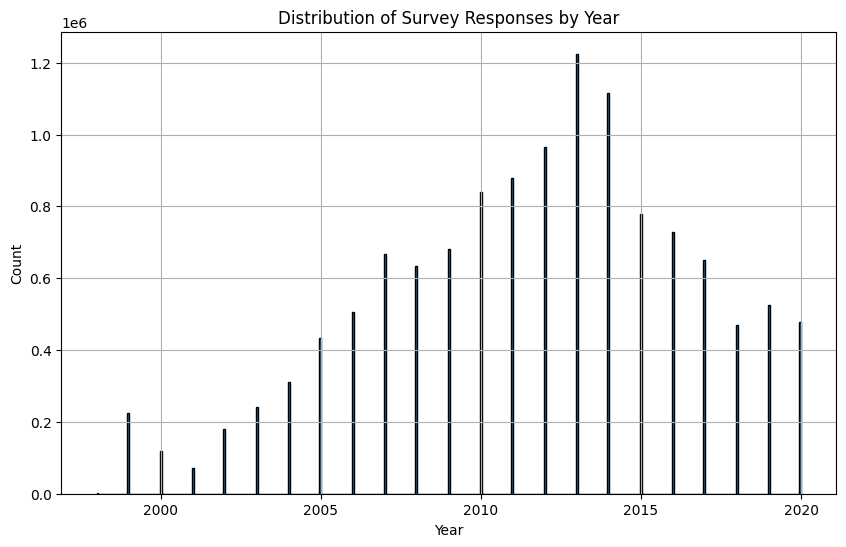


Year distribution:
shape: (24, 2)
┌──────┬────────┐
│ year ┆ count  │
│ ---  ┆ ---    │
│ i32  ┆ u32    │
╞══════╪════════╡
│ null ┆ 107    │
│ 1998 ┆ 1185   │
│ 1999 ┆ 225652 │
│ 2000 ┆ 119067 │
│ 2001 ┆ 72854  │
│ …    ┆ …      │
│ 2016 ┆ 729573 │
│ 2017 ┆ 649852 │
│ 2018 ┆ 468509 │
│ 2019 ┆ 526264 │
│ 2020 ┆ 478218 │
└──────┴────────┘


/tmp/ipykernel_276422/3998661844.py:25: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  print(df.groupby('year').count().sort('year'))
/tmp/ipykernel_276422/3998661844.py:25: DeprecationWarning: `count` is deprecated. It has been renamed to `len`.
  print(df.groupby('year').count().sort('year'))


In [5]:
import polars as pl
import matplotlib.pyplot as plt

# Read and clean the data
df = pl.scan_parquet('data/checkpoints/survey_data.parquet') \
       .select(
           pl.col('record_time').str.replace(r' 200\b', ' 2000').alias('fixed_time')
       ) \
       .select(
           pl.col('fixed_time').str.extract(r'(\d{4})', 1).cast(pl.Int32).alias('year')
       ) \
       .collect()

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(df['year'], bins='auto', edgecolor='black')
plt.title('Distribution of Survey Responses by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Print summary
print("\nYear distribution:")
print(df.groupby('year').count().sort('year'))

In [2]:
import polars as pl

# Read only the needed column and take first 10 rows
df = pl.scan_parquet('data/checkpoints/survey_data.parquet') \
       .select('record_time') \
       .limit(10) \
       .collect()

print(df)

shape: (10, 1)
┌──────────────────────────────┐
│ record_time                  │
│ ---                          │
│ str                          │
╞══════════════════════════════╡
│ Mon Nov 29 04:54:43 EST 1999 │
│ Mon Jun  5 05:45:23 EDT 200  │
│ Mon May 15 14:35:33 EDT 200  │
│ Sun May 21 11:17:49 EDT 200  │
│ Thu May 25 11:40:42 EDT 200  │
│ Sun May 21 11:10:40 EDT 200  │
│ Mon Sep 20 06:03:20 EDT 1999 │
│ Thu Jul 13 16:34:25 EDT 200  │
│ Tue Mar 21 17:11:15 EST 200  │
│ Tue Jul 20 06:42:09 EDT 1999 │
└──────────────────────────────┘
